#### Eleonora Bellasio (15650A)
# <span style="color:orangered">Laboratorio di Simulazione Numerica: Esercitazione 4

### <span style="color:royalblue">Esercizio 04.1
In meccanica statistica la distribuzione di Maxwell-Boltzmann è una distribuzione di probabilità utilizzata per descrivere la velocità delle particelle in un gas ideale. Nella realtà, i gas rarefatti a temperatura ordinaria si comportano in modo molto simile ai gas ideali e la distribuzione delle velocità di Maxwell-Boltzmann è un'approssimazione eccellente per questi gas. 
La formula per un sistema in 3D è:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$

Utilizzando le unità ridotte di LJ (Lunghezza: $\sigma$; Energia: $\epsilon$; Massa: la massa, $m$, delle particelle; Temperatura: $\epsilon/k_B$; velocità: $\sqrt{\epsilon/m}$) la sua forma diventa:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

E' stato modificato il codice di NSL_SIMULATOR (che già contenva l'energia totale (interna) per particella $E/N$, l'energia potenzialeper particella $U/N$, l'energia cinetica per particella $K/N$, la temperatura $T$, e la pressione $P$) includendo il calcolo della distribuzione di Maxwell-Boltzmann $p(v^*,T^*)$ all'interno del codice della Dinamica Molecolare. Si è utilizzata la tecnica del data blocking per ottenere le medie di songolo blocco, i valori medi progressivi e le incertezze progressive per $p(v^*,T^*)$</span>.

Si è approssimata la distribuzione con un istogramma normalizzato su un intervallo appropiato $[0, v_{max}]$ e scegliendo il nuemro di bin in cui suddividere questo intervallo.

### <span style="color:royalblue">Esercizio 04.2

Si è effettuata una simulazione di dinamica molecolare (MD) con un modello di Lennard-Jones nelle seguenti condizioni:
- fase gassosa: $\rho^\star = 0.05$, $T^\star \sim  2.0$ (raggio di cut-off: $r_c = 5.0$)

Si è partiti da una configurazione iniziale con entropia molto bassa, ponendo:
1. Le posizioni iniziali delle particelle in corrispondenza di un cristallo fcc che occupa metà metà del box della simulazione in ongi dimensione,
2. La distribuzione delle velocità iniziali come: $p_\delta(v^*,T^*) = \delta\left( v^* - v_{T^*}\right)$, con $v_{T^*}$ connessa in manera adeguata a $T^*$. A tal proposito, è stato modificao il codice del file $sistem.cpp$ imponendo che ciascuna particella abbia velocità iniziale pari a $\pm v_{T^*}$ per una sola delle tre componenti $v_x$, $v_y$, $v_z$.

Si è effettuata una simulazione con $20$ blocchi da $2000$ step per mostrare che, facendo evolvere queste condizioni iniziali attraverso una simulazione di Dinamica Molecolare, la distribuzione delle velocità tende ad approssimare la distribuzione di Maxwell-Boltzmann.

In una simulazione di Dinamica Molecolare, viene conservata l'energia totale ma non l'energia cinetica e quella potenziale prese individualmente. Il fatto che i valori di queste due forme di energia cambino con l'avanzare della smulazione, fa si che anche il valore della temperatura $T$ del sistema cambi. Quindi, per fare un fit corretto della distribuzione di Maxwell-Boltzmann alla fine della simulazone, mi serve conoscere dai dati la temperauta finale $T_{eff}$ dopo l'evoluzione del sistema.

1.3218707692314715 +- [4.07445413e-05]


<function matplotlib.pyplot.show(close=None, block=None)>

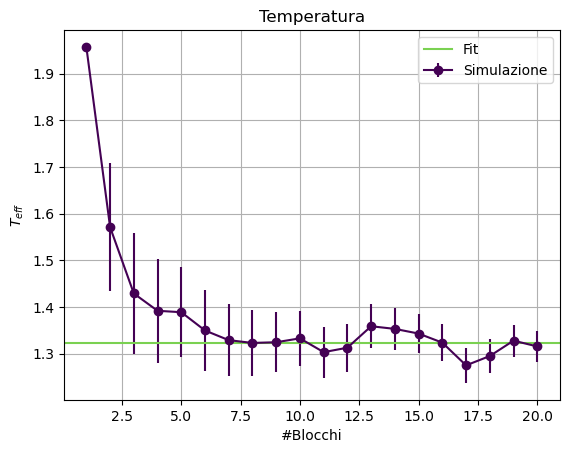

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import os,sys
from scipy.optimize import curve_fit
import pandas as pd

nbins = 30

#Definisco una funzione costante per fare un fit della temperatura di equilibrio
def f(x, c):
    return c

dinp = "04.2/OUTPUT/"
finp1 = dinp + "temperature.dat"

if not os.path.isfile(finp1):
    sys.exit( "file does not exist: " + finp1 )

df_temp = pd.read_csv(finp1, sep='\\s+', comment='#', names=['BLOCK:','ACTUAL_T:','T_AVE:','ERROR:'])
#per il fit considero solo i blocchi finali, i primi divergono troppo dal valore finale della temperatura
df_temp_fit = df_temp[df_temp['BLOCK:']>= 8] 

#Scelgo 6 colori diversi
#https://matplotlib.org/stable/users/explain/colors/colormaps.html
colors = plt.cm.viridis(np.linspace(0,1,6))

p_opt, p_cov = curve_fit(f, df_temp_fit['BLOCK:'], df_temp_fit['ACTUAL_T:'])
print (p_opt[0], '+-', p_cov[0])

plt.errorbar(df_temp['BLOCK:'], df_temp['ACTUAL_T:'], df_temp['ERROR:'], label='Simulazione', color =colors[0], marker='o')
plt.xlabel('#Blocchi')
plt.ylabel(r'$T_{eff}$')
plt.title('Temperatura')
plt.axhline(y=p_opt[0], label='Fit', color =colors[4])
plt.grid(True)
plt.legend()
plt.show

Dal grafico si può notare che il sistema evolve verso una situazione di equilibrio, che corrisponde ad una temperatura $T_{eff} = 1.322$.

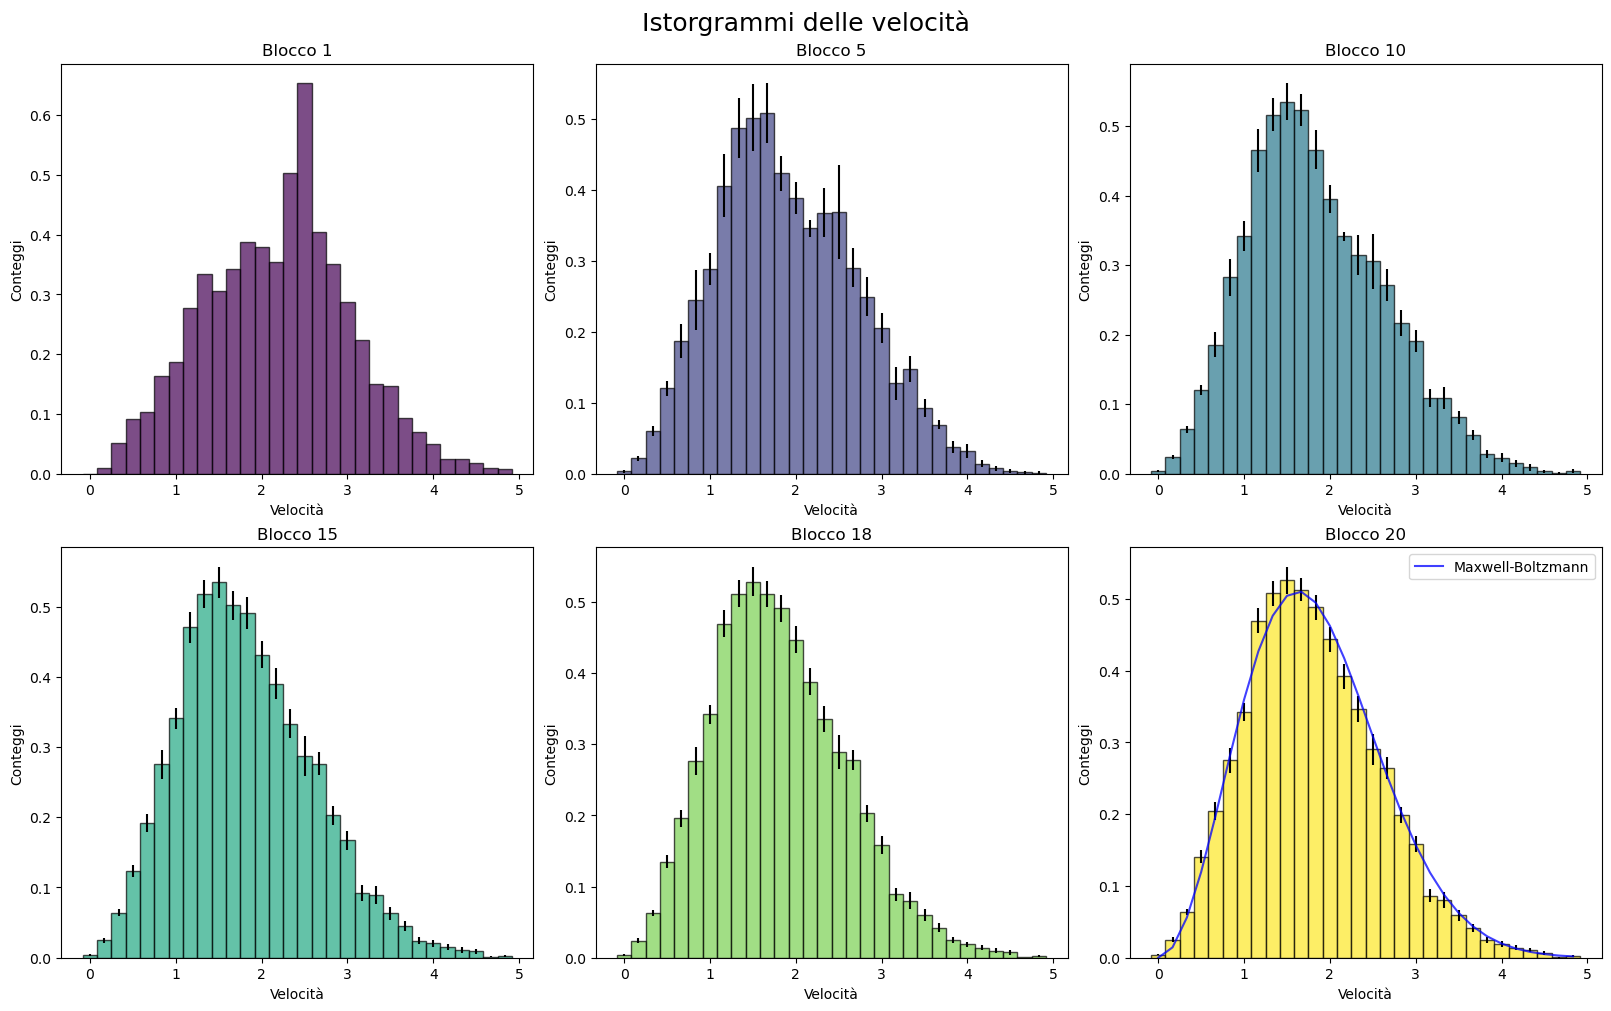

In [19]:
finp2 = dinp + "pofv.dat"

if not os.path.isfile(finp2):
    sys.exit( "file does not exist: " + finp2 )

#Definisco la funzione analitica della distribuzione di Maxwell-Boltzmann per il fit
#xx è la variabile v*, k è il parametro temperatura ALL'EQUILIBRIO
def f_MB(xx, k):
    return (1/pow(2*math.pi*k,3/2))*4*math.pi*(xx**2)*math.exp((-xx**2)/(2*k))

#v_max = 5  #Deve essere come nel cpp
T_eff = 1.3218707692314715 #Copio la temperatura ottenuta alla fine della simulazione
v_max = 5 #Dal cpp

#Metto i dati di output in un dataframe
#Elimino la riga iniziale perchè lo # sfasa le colonne (in alternativa potrei modificare l'output del cpp)
#Indico che il separatore di campo non è la virgola (default) ma una serie di spazi
#Siccome ho eliminato l'intestazione ricreo l'header con names=[...]
df = pd.read_csv(finp2, skiprows=1, sep='\\s+', names=['BLOCK:','POFV:','AVE_POFV:','ERROR:'])
#Filtro i dati di alcuni blocchi precedenti all'ultimo per mostrare l'evoluzione della distribuzuine
df_block01 = df[df['BLOCK:'] == 1]
df_block05 = df[df['BLOCK:'] == 5]
df_block10 = df[df['BLOCK:'] == 10]
df_block15 = df[df['BLOCK:'] == 15]
df_block18 = df[df['BLOCK:'] == 18]
df_block20 = df[df['BLOCK:'] == 20]

#Ricavo il numero di bin dal grafico
n_bins = len(df_block20['BLOCK:'])
#Ricavo il passo tra bin successivi e di conseguenza imposto le x
step = v_max / n_bins
x = np.arange(0,v_max,step)

#Creo una figura con 6 subplots
fig, spl = plt.subplots(2, 3, figsize=(16,10), layout='constrained')  #due righe e tre colonne

spl[0,0].bar(x, df_block01['AVE_POFV:'], yerr=df_block01['ERROR:'], width=v_max/n_bins, color=colors[0], alpha=0.7, edgecolor='black') 
spl[0,1].bar(x, df_block05['AVE_POFV:'], yerr=df_block05['ERROR:'], width=v_max/n_bins, color=colors[1], alpha=0.7, edgecolor='black')
spl[0,2].bar(x, df_block10['AVE_POFV:'], yerr=df_block10['ERROR:'], width=v_max/n_bins, color=colors[2], alpha=0.7, edgecolor='black')
spl[1,0].bar(x, df_block15['AVE_POFV:'], yerr=df_block15['ERROR:'], width=v_max/n_bins, color=colors[3], alpha=0.7, edgecolor='black')
spl[1,1].bar(x, df_block18['AVE_POFV:'], yerr=df_block18['ERROR:'], width=v_max/n_bins, color=colors[4], alpha=0.7, edgecolor='black')
spl[1,2].bar(x, df_block20['AVE_POFV:'], yerr=df_block20['ERROR:'], width=v_max/n_bins, color=colors[5], alpha=0.7, edgecolor='black')
#al grafico dell'ultimo blocco aggiungo la distribuzione teorica

# Valuto la funzione di fit usando lo stesso parametro temperatura del cpp
#Trasformo f in un vettore (f2) per renderla compatibile con le x
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
f2 = np.vectorize(f_MB)
y_fit = f2(x, T_eff)

spl[1,2].plot(x, y_fit, color='blue', alpha=0.75, label='Maxwell-Boltzmann')

spl[0,0].set_title("Blocco 1")
spl[0,0].set_xlabel("Velocità")
spl[0,0].set_ylabel("Conteggi")
spl[0,1].set_title("Blocco 5")
spl[0,1].set_xlabel("Velocità")
spl[0,1].set_ylabel("Conteggi")
spl[0,2].set_title("Blocco 10")
spl[0,2].set_xlabel("Velocità")
spl[0,2].set_ylabel("Conteggi")
spl[1,0].set_title("Blocco 15")
spl[1,0].set_xlabel("Velocità")
spl[1,0].set_ylabel("Conteggi")
spl[1,1].set_title("Blocco 18")
spl[1,1].set_xlabel("Velocità")
spl[1,1].set_ylabel("Conteggi")
spl[1,2].set_title("Blocco 20")
spl[1,2].set_xlabel("Velocità")
spl[1,2].set_ylabel("Conteggi")

#plt.tight_layout() #evito sovrapposizioni
fig.suptitle("Istorgrammi delle velocità", fontsize=18)
plt.legend()

plt.show()

Il sistema evolve dalla configurazione iniziale, con temperatura $T=2$ verso una configurazione con entropia più alta modificando la temperatura. Dai grafici riportati in figura si nota che la distribuzione delle velocità delle le particelle va ad assomigliare sempre di più alla distribuzione di Maxwell-Boltzmann, che è la distribuzione attesa dalla meccanica statistica per un gas ideale all'equilibrio. 

### <span style="color:royalblue">Esercizio 04.3

Nell'esercizio precedente il sistema va verso configurazioni con entropia maggiore. Adesso, partendo dallo stato finale di equilibrio della simulazione di Dinamica Molecolare, si vuole provare a riportare il sistema alla configurazione di entropia molto bassa che si aveva all'inizio dell'esercizio 04.2. Per fare questo si prova a monitorare il comportamento dell'energia potenziale media e della temperatura media in ogni blocco come funzione del tempo in entrambe le direzioni.

Dopo avere portato il sistema all'equilibrio si è invertito il tempo, ovvero:

- si è posto nel file config.xyz la penultima configurazione trovata al punto precedente;
- si è posto nel file conf-1.xyz l'ultima configurazione trovata al punto precedente;
- le particelle all'inizio della simulazione possono occupare tutto il box e non solo metà lato per ogni direzione come accadeva nella fase di equilibrazione;
- si è impostata la temperatura del file input.dat alla temperatura di equilibrio raggiunta precedentemente;
- si riparte utilizando restart=1.

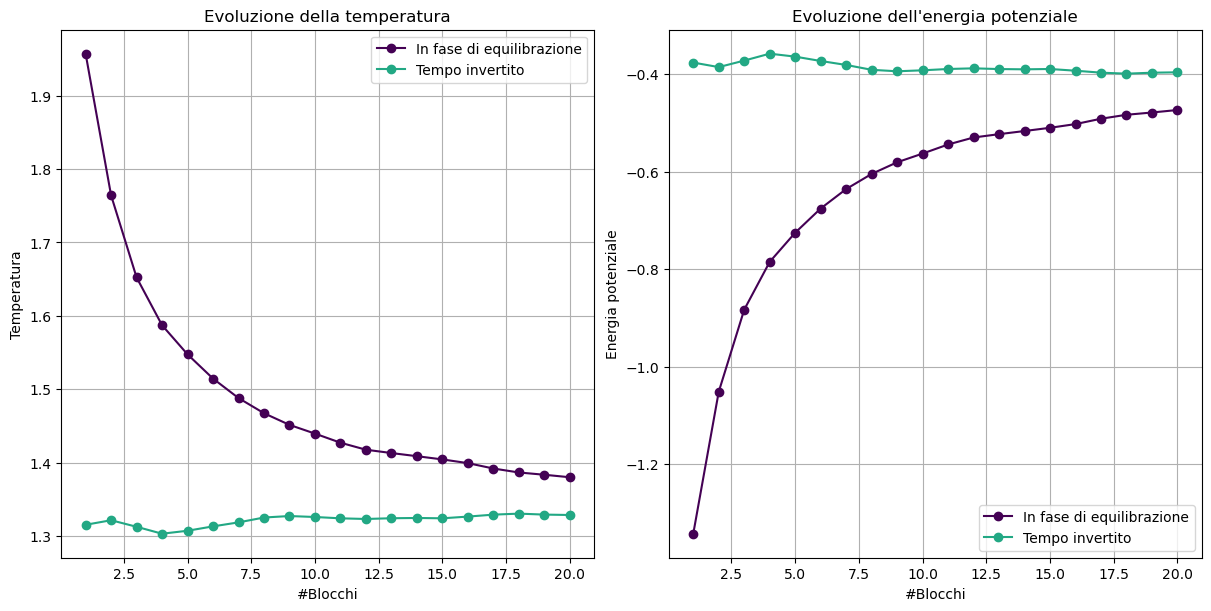

In [20]:
#dinp + finp1 -> dati temperatura 04.2 
finp3 = dinp + "potential_energy.dat"

if not os.path.isfile(finp3):
    sys.exit( "file does not exist: " + finp3 )

dinp1 = "04.3/OUTPUT/"
finp4 = dinp1 + "temperature.dat"
finp5 = dinp1 + "potential_energy.dat"

if not os.path.isfile(finp4):
    sys.exit( "file does not exist: " + finp4 )

if not os.path.isfile(finp5):
    sys.exit( "file does not exist: " + finp5 )

#df_temp contiene dati temperatura 04.2
df_temp_inv = pd.read_csv(finp4, sep='\\s+', comment='#', names=['BLOCK:','ACTUAL_T:','T_AVE:','ERROR:'])
df_pot_en = pd.read_csv(finp3, sep='\\s+', comment='#', names=['BLOCK:','ACTUAL_PE:','PE_AVE:','ERROR:'])
df_pot_en_inv = pd.read_csv(finp5, sep='\\s+', comment='#', names=['BLOCK:','ACTUAL_PE:','PE_AVE:','ERROR:'])

#Creo una figura con 2 subplots, uno per la temperatura e uno per l'energia potenziale
fig1, spl1 = plt.subplots(1, 2, figsize=(12,6), layout='constrained')  #una riga e due colonne

spl1[0].plot(df_temp['BLOCK:'], df_temp['T_AVE:'], label='In fase di equilibrazione', color =colors[0], marker ='o')
spl1[0].plot(df_temp_inv['BLOCK:'], df_temp_inv['T_AVE:'], label='Tempo invertito', color =colors[3], marker ='o')

spl1[0].set_title('Evoluzione della temperatura')
spl1[0].set_xlabel('#Blocchi')
spl1[0].set_ylabel('Temperatura')
spl1[0].legend()
spl1[0].grid(True)

spl1[1].plot(df_pot_en['BLOCK:'], df_pot_en['PE_AVE:'], label='In fase di equilibrazione', color =colors[0], marker ='o')
spl1[1].plot(df_pot_en_inv['BLOCK:'], df_pot_en_inv['PE_AVE:'], label='Tempo invertito', color =colors[3], marker ='o')

spl1[1].set_title("Evoluzione dell'energia potenziale")
spl1[1].set_xlabel('#Blocchi')
spl1[1].set_ylabel('Energia potenziale')
spl1[1].legend()
spl1[1].grid(True)

#plt.tight_layout() #evito sovrapposizioni
fig.suptitle('Confronto tra simulazioni a tempo diretti e invertito', fontsize=18)
plt.legend()

plt.show()

I grafici mostrano che il sistema, dopo avere raggiunto uno stato di maggiore entropia, non può tornatre alla configurazione di partenza in modo spontaneo. In questa osservazione si ritrova il secondo principio della termodinamica, secondo cui l'entropia di un sistema isolato non può diminuire. In particolare, in un primo momento sembra che la dinamica con tempo invertito segua l'andamento della dinamica in fase di equilibrazione, ma, col procedere della simulazione, diventa evidente la divergenza tra le due situazioni. Per spiegare questo fatto, bisogna considerare errori di discretizzazione che vengono accumulati con l'aumentare del tempo e che rendono l'algoritmo coerente con quanto succede durante il processo di dinamica molecolare. 